#**Swin-UperNet Model Training Notebook**

##Step 1: Importing Libraries and Mounting Files from Google Drive

In [ ]:
# Install required packages (run this cell only once)
!pip install torch torchvision torchaudio
!pip install timm==0.9.2
!pip install segmentation-models-pytorch
!pip install torchinfo
!pip install torchmetrics

In [ ]:
# Import necessary libraries
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.cuda.amp import autocast, GradScaler
import numpy as np
import timm
from timm import create_model
import segmentation_models_pytorch as smp
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
import torchmetrics

In [ ]:
# Mount Google Drive if running on Colab and set BASE_DIR for your processed dataset.
from google.colab import drive
IN_COLAB = "google.colab" in str(get_ipython())
if IN_COLAB:
    print("Running in Google Colab: Mounting Drive...")
    drive.mount('/content/drive')
    # Update the BASE_DIR to point to your folder with processed .npy files
    BASE_DIR = "/content/drive/MyDrive/swinunet-medical-segmentation/dataset/processed_dataset"
else:
    BASE_DIR = "/path/to/local/dataset/processed_dataset"

Running in Google Colab: Mounting Drive...
Mounted at /content/drive


## Step 2: Verify GPU and Environment

In [ ]:
# Set device (GPU if available, else CPU)
print("GPU Available:", torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Running on device:", device)

GPU Available: True
Running on device: cuda


## Step 3: Define a PyTorch Dataset for Our Preprocessed .npy Files

Now we’ll create a custom Dataset class that reads our images and masks from the .npy files. This allows us to easily use DataLoader for batching and shuffling. (This is a common practice for PyTorch).

In [ ]:
class ISICDataset(Dataset):
    def __init__(self, images_path, masks_path, transform=None): # We load two .npy files (images & masks). Optionally store a transform if we want to apply augmentations later
        """
        images_path: Path to the .npy file containing image data (shape: (N, H, W, C))
        masks_path : Path to the .npy file containing mask data  (shape: (N, H, W))
        transform  : (Optional) Albumentations transform for on-the-fly augmentations
        """
        # 1. Load images and masks from disk
        self.images = np.load(images_path)  # shape: (N, H, W, C)
        self.masks  = np.load(masks_path)   # shape: (N, H, W)

        # 2. Store the transform if you want data augmentation later
        self.transform = transform

    def __len__(self): # Returns the total number of samples (len(self.images)). PyTorch’s DataLoader uses this to iterate
        """Return the total number of samples in this dataset."""
        return len(self.images)

    def __getitem__(self, idx): # Retrieves one (image, mask) pair at index idx
        """
        Retrieve the sample (image, mask) at index 'idx'.
        Apply optional augmentation transforms.
        Convert to PyTorch tensors if no transform is provided.
        """
        # 1. Get the raw numpy image and mask
        image = self.images[idx]  # shape: (H, W, C)
        mask  = self.masks[idx]   # shape: (H, W)

        # 2. If we have an Albumentations transform, apply it
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented["image"]  # Already a torch tensor if using ToTensorV2
            mask  = augmented["mask"]
        else:
            # Convert to PyTorch tensors manually
            image = torch.from_numpy(image).permute(2, 0, 1).float()
            mask  = torch.from_numpy(mask).long()

        # 3. Return the processed image and mask
        return image, mask

## Step 4: Create a DataLoader for Training & Validation

Now that we have our ISICDataset class defined, let’s set up the DataLoader. This allows us to:

1. Batch our images and masks (e.g., batches of size 8).
2. Shuffle the data for training.
3. Potentially use multiple workers to speed up data loading.

In [ ]:
# Define file paths for training, validation, and test sets
train_images_path = os.path.join(BASE_DIR, "train_images.npy")
train_masks_path  = os.path.join(BASE_DIR, "train_masks.npy")
val_images_path   = os.path.join(BASE_DIR, "val_images.npy")
val_masks_path    = os.path.join(BASE_DIR, "val_masks.npy")
test_images_path  = os.path.join(BASE_DIR, "test_images.npy")
test_masks_path   = os.path.join(BASE_DIR, "test_masks.npy")

# Create dataset instances
train_dataset = ISICDataset(train_images_path, train_masks_path)
val_dataset   = ISICDataset(val_images_path, val_masks_path)
test_dataset  = ISICDataset(test_images_path, test_masks_path)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=4, pin_memory=True)

# Quick test: Display batch shapes
train_batch = next(iter(train_loader))
images, masks = train_batch
print("Train Images batch shape:", images.shape)  # Expected: [B, 3, H, W]
print("Train Masks batch shape:", masks.shape)    # Expected: [B, H, W]

# Test that test dataset is properly loaded
test_batch = next(iter(test_loader))
test_images, test_masks = test_batch
print("Test Images batch shape:", test_images.shape)
print("Test Masks batch shape:", test_masks.shape)

Train Images batch shape: torch.Size([8, 3, 256, 256])
Train Masks batch shape: torch.Size([8, 256, 256])
Test Images batch shape: torch.Size([8, 3, 256, 256])
Test Masks batch shape: torch.Size([8, 256, 256])


## Step 5: Define the Baseline Swin-UNet Model

In this step, we define our **Swin-Unet** model, which replaces the standard CNN encoder in U-Net with a **Swin Transformer V2** encoder.

### **What is Swin-Unet?**
Swin-Unet is an advanced segmentation model that leverages **Swin Transformer-based feature extraction** while maintaining the **U-Net-style decoder** for upsampling.  
This approach allows us to benefit from **global self-attention** in the encoder while keeping the **lightweight, convolutional decoder** structure intact.

### **How We Build the Model**
1. **Encoder: Swin Transformer V2** (Pretrained on ImageNet-22K)  
   - Extracts multi-scale hierarchical features.  
   - Pretrained weights allow faster convergence and better performance.  
2. **Decoder: U-Net Style CNN Decoder**  
   - Upsamples the feature maps back to the original image size.  
   - Uses skip connections from encoder outputs to refine segmentation maps.  
3. **Segmentation Head**  
   - A **final convolutional layer** produces the binary segmentation mask output.  

### **Implementation Details**
- We use **timm** to load the Swin Transformer V2 backbone.  
- The **UnetDecoder from segmentation-models-pytorch (SMP)** reconstructs the segmentation mask.  
- We ensure **feature map compatibility** between the encoder and decoder.  

**Model Architecture Overview**
- **Input Image Size:** `(3, 256, 256)`
- **Pretrained Weights:** ImageNet-22K  
- **Number of Classes:** `1` (Binary Segmentation: Lesion vs. Background)  

---

In [ ]:
# -------------------------------
# Define Pyramid Pooling Module (with GroupNorm)
# -------------------------------
class PyramidPoolingModule(nn.Module):
    def __init__(self, in_channels, pool_sizes=[1, 2, 3, 6]):
        super().__init__()
        # Use GroupNorm instead of BatchNorm to handle small spatial sizes.
        self.pool_layers = nn.ModuleList([
            nn.Sequential(
                nn.AdaptiveAvgPool2d(pool_size),
                nn.Conv2d(in_channels, in_channels // 4, kernel_size=1, bias=False),
                nn.GroupNorm(num_groups=8, num_channels=in_channels // 4),
                nn.ReLU(inplace=True)
            ) for pool_size in pool_sizes
        ])
        total_channels = in_channels + len(pool_sizes) * (in_channels // 4)
        self.conv = nn.Conv2d(total_channels, in_channels, kernel_size=1, bias=False)

    def forward(self, x):
        pooled_features = [x]
        for layer in self.pool_layers:
            pooled = layer(x)
            pooled = F.interpolate(pooled, size=x.shape[2:], mode='bilinear', align_corners=False)
            pooled_features.append(pooled)
        x = torch.cat(pooled_features, dim=1)
        x = self.conv(x)
        return x

# -------------------------------
# Define UPerNet-Style Decoder
# -------------------------------
class UPerNetDecoder(nn.Module):
    def __init__(self, encoder_channels=[96, 192, 384, 768], num_classes=1):
        """
        For a 256x256 input, encoder feature maps are expected to be:
        f0: [B, 96, 64, 64], f1: [B, 192, 32, 32],
        f2: [B, 384, 16, 16], f3: [B, 768, 8, 8].
        """
        super().__init__()
        self.ppm = PyramidPoolingModule(encoder_channels[-1])

        self.lateral_conv2 = nn.Conv2d(encoder_channels[2], encoder_channels[-1], kernel_size=1)
        self.conv3 = nn.Conv2d(encoder_channels[-1], encoder_channels[2], kernel_size=1)

        self.lateral_conv1 = nn.Conv2d(encoder_channels[1], 384, kernel_size=1)
        self.conv2 = nn.Conv2d(384, encoder_channels[1], kernel_size=1)

        self.lateral_conv0 = nn.Conv2d(encoder_channels[0], encoder_channels[1], kernel_size=1)
        self.conv1 = nn.Conv2d(encoder_channels[1], encoder_channels[0], kernel_size=1)

        self.segmentation_head = nn.Conv2d(encoder_channels[0], num_classes, kernel_size=1)

    def forward(self, features):
        f0, f1, f2, f3 = features

        x3 = self.ppm(f3)  # [B, 768, 8, 8]
        x3_up = F.interpolate(x3, size=f2.shape[2:], mode="bilinear", align_corners=False)  # 16x16
        f2_lat = self.lateral_conv2(f2)  # [B, 768, 16, 16]
        fuse2 = x3_up + f2_lat
        fuse2 = self.conv3(fuse2)  # [B, 384, 16, 16]

        fuse2_up = F.interpolate(fuse2, size=f1.shape[2:], mode="bilinear", align_corners=False)  # 32x32
        f1_lat = self.lateral_conv1(f1)  # [B, 384, 32, 32]
        fuse1 = fuse2_up + f1_lat
        fuse1 = self.conv2(fuse1)  # [B, 192, 32, 32]

        fuse1_up = F.interpolate(fuse1, size=f0.shape[2:], mode="bilinear", align_corners=False)  # 64x64
        f0_lat = self.lateral_conv0(f0)  # [B, 192, 64, 64]
        fuse0 = fuse1_up + f0_lat
        fuse0 = self.conv1(fuse0)  # [B, 96, 64, 64]

        x_out = F.interpolate(fuse0, scale_factor=4, mode="bilinear", align_corners=False)
        output = self.segmentation_head(x_out)  # [B, num_classes, 256, 256]
        return output

# -------------------------------
# Define the Combined Model
# -------------------------------
class SwinUPerNet(nn.Module):
    def __init__(self, num_classes=1):
        super().__init__()
        self.encoder = timm.create_model(
            "swinv2_tiny_window8_256",
            pretrained=True,
            features_only=True
        )
        encoder_channels = self.encoder.feature_info.channels()
        self.decoder = UPerNetDecoder(encoder_channels, num_classes)

    def forward(self, x):
        features = self.encoder(x)
        features = [f.permute(0, 3, 1, 2) for f in features]
        output = self.decoder(features)
        return output

# -------------------------------
# Instantiate and Test the Model
# -------------------------------
if __name__ == "__main__":
    model = SwinUPerNet(num_classes=1)
    print("SwinUPerNet Model Summary:")
    # Explicitly print the summary output
    print(summary(model, input_size=(1, 3, 256, 256)))

    # Test a forward pass with a dummy input
    dummy_input = torch.randn(1, 3, 256, 256).to(device)
    output = model(dummy_input)
    print("Output shape:", output.shape)

SwinUPerNet Model Summary:
Layer (type:depth-idx)                             Output Shape              Param #
SwinUPerNet                                        [1, 1, 256, 256]          --
├─FeatureListNet: 1-1                              [1, 64, 64, 96]           --
│    └─PatchEmbed: 2-1                             [1, 64, 64, 96]           --
│    │    └─Conv2d: 3-1                            [1, 96, 64, 64]           4,704
│    │    └─LayerNorm: 3-2                         [1, 64, 64, 96]           192
│    └─SwinTransformerV2Stage: 2-2                 [1, 64, 64, 96]           --
│    │    └─Identity: 3-3                          [1, 64, 64, 96]           --
│    │    └─ModuleList: 3-4                        --                        229,638
│    └─SwinTransformerV2Stage: 2-3                 [1, 32, 32, 192]          --
│    │    └─PatchMerging: 3-5                      [1, 32, 32, 192]          74,112
│    │    └─ModuleList: 3-6                        --                      

## Step 6: Test Swin-UNet Model on a Single Batch

Before we dive into training, we want to verify that our model is working correctly by running it on a single batch of images. This helps us catch potential issues before we begin full-scale training.

Motivation:

Ensures the model is compatible with the input data.
Confirms that the input and output shapes are correct.
Identifies potential errors early, preventing time wastage during training.

In [ ]:
# Move a batch of images to the correct device
images, masks = next(iter(train_loader))
images, masks = images.to(device), masks.to(device)

# Forward pass through the model
outputs = model(images)

# Print output shape
print("Output shape:", outputs.shape)

Output shape: torch.Size([8, 1, 256, 256])


## Step 7: Define the Loss Function

For binary segmentation (lesion vs. background), we need a loss function that effectively measures how well the predicted masks match the ground truth. For this project, we will be using Dice Loss, which is a common choice for medical segmentation tasks.

In [ ]:
# Define loss functions.
# We combine Dice Loss (good for segmentation) with BCEWithLogitsLoss for pixel-wise classification.
dice_loss = smp.losses.DiceLoss(mode="binary")
bce_loss = nn.BCEWithLogitsLoss()

def combined_loss(y_pred, y_true):
    # Ensure we are working with the correct tensor format
    if isinstance(y_pred, (list, tuple)):
        y_pred = y_pred[0]  # Extract first tensor if model outputs a list

    return 0.5 * bce_loss(y_pred, y_true) + 0.5 * dice_loss(y_pred, y_true)

# %% [code]
# **Corrected Metric Definitions**
dice_metric = torchmetrics.Dice(num_classes=1, multiclass=False, threshold=0.5).to(device)
iou_metric  = torchmetrics.JaccardIndex(task="binary").to(device)

# Quick test: Check loss computation for one batch
y_pred = model(images)  # Forward pass

# Reshape masks to have a channel dimension (add 1 at dim=1) and convert to float
# unsqueeze(1) adds the missing channel dimension to masks, making it [8, 1, 256, 256], which matches the model output
masks = masks.unsqueeze(1).float().to(device)

# Compute loss
loss = combined_loss(y_pred, masks)
print(f"Loss for this batch: {loss.item():.4f}")

Loss for this batch: 0.6715


## Step 8: Define the Optimizer

We’ll use Adam as our optimizer, which is commonly used in deep learning due to its adaptive learning rate and efficiency.

In [ ]:
# Define the optimizer.
optimizer = optim.AdamW(model.parameters(), lr=5e-5, weight_decay=1e-4)
# Define the learning rate scheduler (must be defined before using `scheduler.step`)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=2, verbose=True)
print("Optimizer and scheduler initialized successfully!")

Optimizer and scheduler initialized successfully!


In [ ]:
# Create a dummy batch (8 images, 3 channels, 256x256 size)
dummy_images = torch.randn(8, 3, 256, 256).to(device)
dummy_masks = torch.randint(0, 2, (8, 256, 256)).to(device)  # Binary ground truth masks

# Ensure masks have the correct shape
dummy_masks = dummy_masks.unsqueeze(1).float()  # Shape: [8, 1, 256, 256]

# Forward pass
optimizer.zero_grad()
preds = model(dummy_images)

# Ensure preds is a tensor (handle potential list output)
if isinstance(preds, (list, tuple)):
    preds = preds[0]

# Compute loss
loss = combined_loss(preds, dummy_masks)

# Backward pass
loss.backward()

# Optimizer step
optimizer.step()

# Check if gradients are non-zero
grad_norm = sum(p.grad.norm().item() for p in model.parameters() if p.grad is not None)
print(f"Optimizer Step Successful! Loss: {loss.item():.4f}, Total Gradient Norm: {grad_norm:.4f}")

Optimizer Step Successful! Loss: 0.5897, Total Gradient Norm: 5.4174


## Step 9: Implement Training and Validation Loops

In [ ]:
def train_one_epoch(model, train_loader, optimizer, loss_fn, dice_metric, iou_metric, device):
    """Trains the model for one epoch and returns loss, Dice score, and IoU score."""
    model.train()
    running_loss, running_dice, running_iou = 0.0, 0.0, 0.0

    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        preds = model(images)

        # Ensure preds is a single tensor
        if isinstance(preds, (list, tuple)):
            preds = preds[0]

        # Ensure masks have the correct shape
        loss = loss_fn(preds, masks.unsqueeze(1).float())  # Add missing channel dim
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        # Compute Dice & IoU for training:
        preds = torch.sigmoid(preds)  # Convert logits to probabilities
        pred_binary = (preds > 0.5).int()  # Binarize predictions
        running_dice += dice_metric(pred_binary, masks.unsqueeze(1).int()).item()
        running_iou += iou_metric(pred_binary, masks.unsqueeze(1).int()).item()

    return (
        running_loss / len(train_loader),
        running_dice / len(train_loader),
        running_iou / len(train_loader),
    )

def validate_one_epoch(model, val_loader, loss_fn, dice_metric, iou_metric, device):
    """Validates the model and returns loss, Dice score, and IoU score."""
    model.eval()
    val_loss, val_dice, val_iou = 0.0, 0.0, 0.0

    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            preds = model(images)

            # Ensure preds is a single tensor
            if isinstance(preds, (list, tuple)):
                preds = preds[0]

            # Ensure masks have the correct shape
            loss = loss_fn(preds, masks.unsqueeze(1).float())  # Add missing channel dim
            val_loss += loss.item()

            # Compute Dice & IoU for validation:
            preds = torch.sigmoid(preds)
            pred_binary = (preds > 0.5).int()
            val_dice += dice_metric(pred_binary, masks.unsqueeze(1).int()).item()
            val_iou += iou_metric(pred_binary, masks.unsqueeze(1).int()).item()

    return (
        val_loss / len(val_loader),
        val_dice / len(val_loader),
        val_iou / len(val_loader),
    )

In [ ]:
# Fetch one batch of training data
images, masks = next(iter(train_loader))
images, masks = images.to(device), masks.to(device)

# Ensure masks have correct shape before passing to loss
masks = masks.unsqueeze(1).float()  # Convert to [batch, 1, 256, 256]

# Ensure model is in training mode
model.train()

# Forward pass (simulate one training step)
optimizer.zero_grad()
preds = model(images)

# Ensure preds is a single tensor
if isinstance(preds, (list, tuple)):
    preds = preds[0]

# Compute loss
loss = combined_loss(preds, masks)  # Now `masks` has the correct shape!
loss.backward()
optimizer.step()

# Compute Dice & IoU for training
preds = torch.sigmoid(preds)  # Convert logits to probabilities
pred_binary = (preds > 0.5).int()  # Binarize predictions
train_dice = dice_metric(pred_binary, masks.int()).item()
train_iou = iou_metric(pred_binary, masks.int()).item()

print(f"Test Successful! Loss: {loss.item():.4f}, Dice: {train_dice:.4f}, IoU: {train_iou:.4f}")

# ------------------------------
# Now test validation function
# ------------------------------
model.eval()
with torch.no_grad():
    preds = model(images)

    # Ensure preds is a single tensor
    if isinstance(preds, (list, tuple)):
        preds = preds[0]

    # Compute loss
    val_loss = combined_loss(preds, masks)  # Now `masks` has the correct shape!

    # Compute Dice & IoU for validation
    preds = torch.sigmoid(preds)
    pred_binary = (preds > 0.5).int()
    val_dice = dice_metric(pred_binary, masks.int()).item()
    val_iou = iou_metric(pred_binary, masks.int()).item()

print(f"Validation Test Successful! Loss: {val_loss.item():.4f}, Dice: {val_dice:.4f}, IoU: {val_iou:.4f}")

Test Successful! Loss: 0.6305, Dice: 0.0839, IoU: 0.0438
Validation Test Successful! Loss: 0.5783, Dice: 0.0728, IoU: 0.0378



Now that the training and validation functions are defined, the next step is to train the model over multiple epochs while tracking performance.

This loop will:

1. Train the model on the training dataset.
2. Validate the model after each epoch.
3. Save the model if the validation loss improves.

In [ ]:
# Initialize GradScaler for Mixed Precision Training
scaler = torch.amp.GradScaler()

# Lists to store loss and metric history
train_losses = []
val_losses = []
train_dice_scores = []
val_dice_scores = []
train_iou_scores = []
val_iou_scores = []

num_epochs = 10
best_val_dice = 0.0  # Track best validation Dice score

for epoch in range(num_epochs):
    # Train one epoch & track Dice/IoU for training
    model.train()
    train_loss = 0.0
    train_dice = 0.0
    train_iou = 0.0

    for batch in train_loader:
        # Ensure correct unpacking (handles datasets with extra metadata)
        if len(batch) == 2:
            images, masks = batch
        else:
            images, masks, _ = batch  # Ignore extra metadata if present

        images, masks = images.to(device), masks.to(device)

        optimizer.zero_grad()  # Reset gradients

        # Forward pass with Mixed Precision
        with torch.amp.autocast(device_type="cuda"):
            preds = model(images)
            if isinstance(preds, (list, tuple)):
                preds = preds[0]  # Extract main output if model returns multiple values
            loss = combined_loss(preds, masks.unsqueeze(1).float())

        # Backward pass with GradScaler
        scaler.scale(loss).backward()
        scaler.step(optimizer)  # Step optimizer using scaled gradients
        scaler.update()  # Update GradScaler

        train_loss += loss.item()

        # Compute Dice & IoU for training
        preds = torch.sigmoid(preds)  # Convert logits to probabilities
        pred_binary = (preds > 0.5).int()  # Binarize predictions
        train_dice += dice_metric(pred_binary, masks.unsqueeze(1).int()).item()
        train_iou += iou_metric(pred_binary, masks.unsqueeze(1).int()).item()

    # Average training loss, Dice, and IoU
    train_loss /= len(train_loader)
    train_dice /= len(train_loader)
    train_iou /= len(train_loader)

    train_losses.append(train_loss)
    train_dice_scores.append(train_dice)
    train_iou_scores.append(train_iou)

    # Validate one epoch
    model.eval()
    val_loss = 0.0
    val_dice = 0.0
    val_iou = 0.0

    with torch.no_grad():
        for batch in val_loader:
            if len(batch) == 2:
                images, masks = batch
            else:
                images, masks, _ = batch

            images, masks = images.to(device), masks.to(device)

            with torch.amp.autocast(device_type="cuda"):  # Use Mixed Precision in validation
                preds = model(images)
                if isinstance(preds, (list, tuple)):
                    preds = preds[0]
                loss = combined_loss(preds, masks.unsqueeze(1).float())

            val_loss += loss.item()

            # Compute Dice & IoU for validation
            preds = torch.sigmoid(preds)
            pred_binary = (preds > 0.5).int()
            val_dice += dice_metric(pred_binary, masks.unsqueeze(1).int()).item()
            val_iou += iou_metric(pred_binary, masks.unsqueeze(1).int()).item()

    # Average validation loss, Dice, and IoU
    val_loss /= len(val_loader)
    val_dice /= len(val_loader)
    val_iou /= len(val_loader)

    val_losses.append(val_loss)
    val_dice_scores.append(val_dice)
    val_iou_scores.append(val_iou)

    print(f"Epoch [{epoch+1}/{num_epochs}]: "
          f"Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}, "
          f"Train Dice={train_dice:.4f}, Val Dice={val_dice:.4f}, "
          f"Train IoU={train_iou:.4f}, Val IoU={val_iou:.4f}")

    # Save best model if validation Dice improves
    if val_dice > best_val_dice:
        best_val_dice = val_dice
        torch.save(model.state_dict(), "best_swin_upernet.pth")
        print(f">>> Best model saved based on Dice Score: {val_dice:.4f}")
    # Step LR scheduler
    scheduler.step(val_loss)

Epoch [1/10]: Train Loss=0.1090, Val Loss=0.1507, Train Dice=0.9083, Val Dice=0.8866, Train IoU=0.8347, Val IoU=0.7973
>>> Best model saved based on Dice Score!
Epoch [2/10]: Train Loss=0.0978, Val Loss=0.1333, Train Dice=0.9166, Val Dice=0.8983, Train IoU=0.8486, Val IoU=0.8161
>>> Best model saved based on Dice Score!
Epoch [3/10]: Train Loss=0.0877, Val Loss=0.1674, Train Dice=0.9255, Val Dice=0.8791, Train IoU=0.8629, Val IoU=0.7863
Epoch [4/10]: Train Loss=0.0781, Val Loss=0.1502, Train Dice=0.9333, Val Dice=0.8931, Train IoU=0.8760, Val IoU=0.8084
Epoch [5/10]: Train Loss=0.0711, Val Loss=0.1385, Train Dice=0.9385, Val Dice=0.9004, Train IoU=0.8851, Val IoU=0.8211
>>> Best model saved based on Dice Score!
Epoch [6/10]: Train Loss=0.0619, Val Loss=0.1508, Train Dice=0.9460, Val Dice=0.8941, Train IoU=0.8982, Val IoU=0.8112
Epoch [7/10]: Train Loss=0.0562, Val Loss=0.1647, Train Dice=0.9510, Val Dice=0.8899, Train IoU=0.9069, Val IoU=0.8036
Epoch [8/10]: Train Loss=0.0542, Val Loss

## Step 10: Load the Best Model

After training, we reload the best model (saved during training) to evaluate it on the test set.
- **`SwinUnet(num_classes=1).to(device)`** → Recreates the model architecture.
- **`load_state_dict(torch.load("best_swinunet_tiny.pth"))`** → Loads the saved weights.
- **`model.eval()`** → Sets the model to inference mode (disables dropout, batch norm updates).

In [ ]:
# Re-instantiate the model with the same architecture
best_model = SwinUPerNet(num_classes=1).to(device)  # Ensure correct model name

# Load the best saved model checkpoint
best_model.load_state_dict(torch.load("best_swin_upernet.pth"))  # Correct filename

# Set model to evaluation mode
best_model.eval()

print("Best trained Swin-UPerNet model loaded successfully!")

Best trained Swin-UPerNet model loaded successfully!


<ipython-input-18-dc6fa6bba78c>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load("best_swin_upernet.pth"))  # Correct filename


## Step 11: Plotting losses, Dice Scores, and IoU Scores Over Epochs

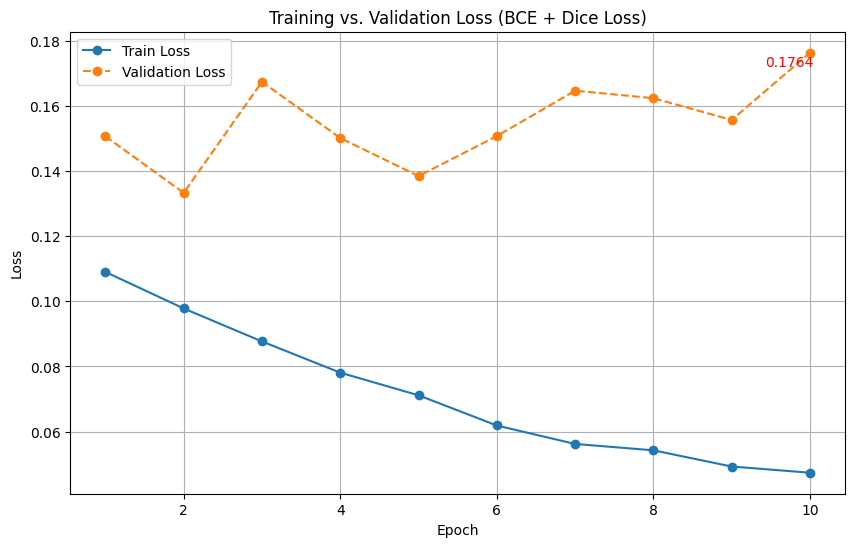

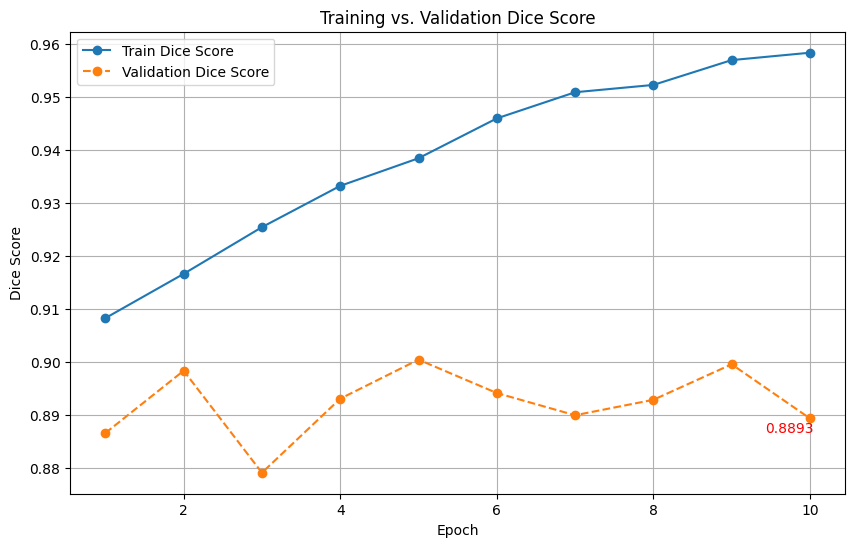

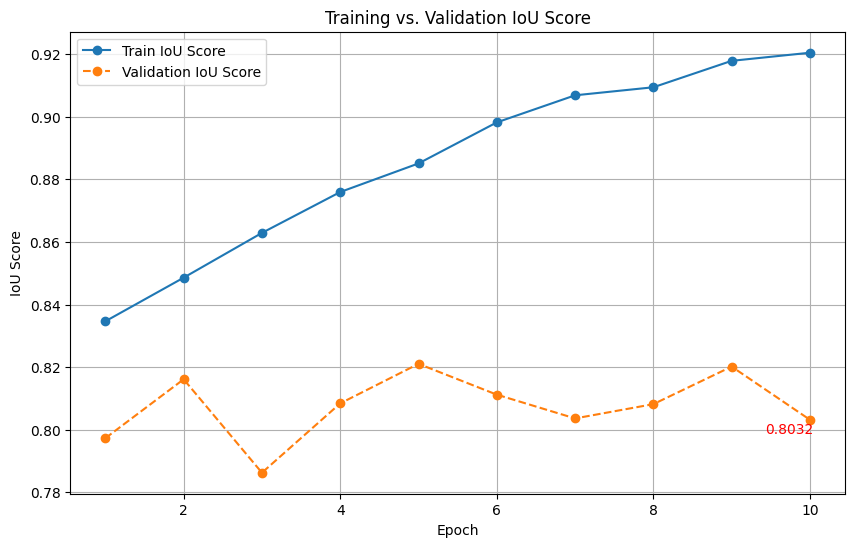

In [ ]:
# Define the epoch range
epochs = range(1, num_epochs + 1)

# Plot Training vs Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, marker='o', linestyle='-', label='Train Loss')
plt.plot(epochs, val_losses, marker='o', linestyle='--', label='Validation Loss')
plt.title('Training vs. Validation Loss (BCE + Dice Loss)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.annotate(f"{val_losses[-1]:.4f}", (epochs[-1], val_losses[-1]), textcoords="offset points", xytext=(-15,-10), ha='center', fontsize=10, color='red')
plt.show()

# Plot Training vs Validation Dice Score
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_dice_scores, marker='o', linestyle='-', label='Train Dice Score')
plt.plot(epochs, val_dice_scores, marker='o', linestyle='--', label='Validation Dice Score')
plt.title('Training vs. Validation Dice Score')
plt.xlabel('Epoch')
plt.ylabel('Dice Score')
plt.legend()
plt.grid(True)
plt.annotate(f"{val_dice_scores[-1]:.4f}", (epochs[-1], val_dice_scores[-1]), textcoords="offset points", xytext=(-15,-10), ha='center', fontsize=10, color='red')
plt.show()

# Plot Training vs Validation IoU Score
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_iou_scores, marker='o', linestyle='-', label='Train IoU Score')
plt.plot(epochs, val_iou_scores, marker='o', linestyle='--', label='Validation IoU Score')
plt.title('Training vs. Validation IoU Score')
plt.xlabel('Epoch')
plt.ylabel('IoU Score')
plt.legend()
plt.grid(True)
plt.annotate(f"{val_iou_scores[-1]:.4f}", (epochs[-1], val_iou_scores[-1]), textcoords="offset points", xytext=(-15,-10), ha='center', fontsize=10, color='red')
plt.show()

## Step 12: Pick a Random Test Image for Visualization

In [ ]:
# 1. Specify the paths to your test images and masks
test_images_path = f"{BASE_DIR}/test_images.npy"
test_masks_path  = f"{BASE_DIR}/test_masks.npy"

# 2. Instantiate the test dataset
test_dataset = ISICDataset(
    images_path=test_images_path,
    masks_path=test_masks_path,
    transform=None  # Ensure same preprocessing as training
)
# Quick check
print(f"Test dataset size: {len(test_dataset)} samples")

Test dataset size: 1000 samples


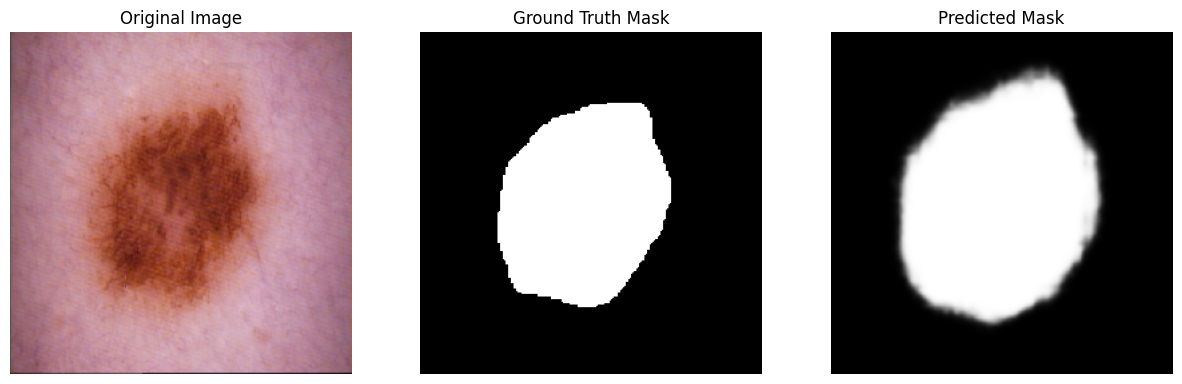

In [ ]:
# 4. Get a random test sample
random_index = random.randint(0, len(test_dataset) - 1)
image, mask = test_dataset[random_index]  # Load image & mask from test dataset

# Convert image to batch format
image_tensor = image.unsqueeze(0).to(device)

# 5. Get model prediction
with torch.no_grad():
    pred_mask = best_model(image_tensor)  # Forward pass
    pred_mask = torch.sigmoid(pred_mask)  # Apply sigmoid activation

    # Ensure correct shape (remove ALL singleton dimensions)
    pred_mask = pred_mask.squeeze().cpu().numpy()  # Shape → (256, 256)

    # Clip values to [0,1] for safe visualization
    pred_mask = np.clip(pred_mask, 0, 1)

# Convert original image & mask to NumPy for visualization
image_np = image.permute(1, 2, 0).cpu().numpy()  # Change shape from (C, H, W) → (H, W, C)
mask_np = mask.cpu().numpy()  # Convert ground truth mask to NumPy

# 6. Plot images side by side
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].imshow(image_np)
ax[0].set_title("Original Image")
ax[0].axis("off")

ax[1].imshow(mask_np, cmap="gray")
ax[1].set_title("Ground Truth Mask")
ax[1].axis("off")

ax[2].imshow(pred_mask, cmap="gray")
ax[2].set_title("Predicted Mask")
ax[2].axis("off")

plt.show()

## Step 13: Compute Evaluation Metrics

In [ ]:
# Define metric functions explicitly for **binary segmentation**
dice_metric = torchmetrics.Dice(num_classes=1, threshold=0.5, average="micro", multiclass=False).to(device)
iou_metric = torchmetrics.JaccardIndex(task="binary").to(device)

# Convert NumPy arrays back to PyTorch tensors (ensure correct shape)
pred_mask_tensor = torch.tensor(pred_mask).unsqueeze(0).to(device)  # Shape → (1, 256, 256)
mask_tensor = torch.tensor(mask).unsqueeze(0).to(device)  # Shape → (1, 256, 256)

# Convert tensors to binary masks
pred_binary = (pred_mask_tensor > 0.5).int()  # Convert predictions to int
mask_binary = (mask_tensor > 0.5).int()  # Convert ground truth mask to int

# Compute Dice and IoU scores
dice_score = dice_metric(pred_binary, mask_binary).item()
iou_score = iou_metric(pred_binary, mask_binary).item()

# Display results
print(f"Dice Score: {dice_score:.4f}")
print(f"IoU Score: {iou_score:.4f}")

Dice Score: 0.8469
IoU Score: 0.7345


<ipython-input-27-80fb2641d4f2>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask_tensor = torch.tensor(mask).unsqueeze(0).to(device)  # Shape → (1, 256, 256)


## Step 14: Evaluating the Entire Test Set

In [ ]:
# Run evaluation on the entire test set
best_model.eval()  # Ensure model is in evaluation mode

test_dice, test_iou = 0.0, 0.0
num_samples = 0

with torch.no_grad():
    for images, masks in test_loader:
        images, masks = images.to(device), masks.to(device)

        # Forward pass
        preds = best_model(images)
        preds = torch.sigmoid(preds)  # Convert logits to probabilities
        pred_binary = (preds > 0.5).int()  # Binarize predictions

        # Compute Dice & IoU
        test_dice += dice_metric(pred_binary, masks.unsqueeze(1).int()).item()
        test_iou += iou_metric(pred_binary, masks.unsqueeze(1).int()).item()
        num_samples += 1

# Compute average metrics
test_dice /= num_samples
test_iou /= num_samples

print(f"Final Test Dice Score: {test_dice:.4f}")
print(f"Final Test IoU Score: {test_iou:.4f}")

Final Test Dice Score: 0.8848
Final Test IoU Score: 0.7987


## Step 15: Saving the Model In Goole Drive

In [ ]:
# Define the model save directory
MODEL_DIR = "/content/drive/MyDrive/swinunet-medical-segmentation/models"

# Ensure the directory exists
os.makedirs(MODEL_DIR, exist_ok=True)

# Define path to save the model
MODEL_PATH = os.path.join(MODEL_DIR, "best_swinupernet.pth")

# Load the best model from training before saving
best_model = SwinUPerNet(num_classes=1).to(device)  # Ensure correct architecture
best_model.load_state_dict(torch.load("best_swin_upernet.pth", map_location=device), strict=False)
best_model.eval()  # Set to evaluation mode

# Save the final best model
torch.save(best_model.state_dict(), MODEL_PATH)

print(f"Model successfully saved at: {MODEL_PATH}")

<ipython-input-30-4a346fede696>:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load("best_swin_upernet.pth", map_location=device), strict

Model successfully saved at: /content/drive/MyDrive/swinunet-medical-segmentation/models/best_swinupernet.pth
